### Deep Learning Robin MASLIAH

* Pour cet exercice j'ai fait le choix d'utiliser Keras.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Create your first MLP in Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

from sklearn.preprocessing import LabelEncoder
from keras import regularizers
from keras.utils import np_utils

from keras.models import model_from_json

/home/robin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading and investigating the data

In [117]:
train_images_fname = 'db_train.raw'
train_labels_fname = 'label_train.txt'

val_images_fname    = 'db_val.raw'


# number of images
num_train_images = 111430
num_valid_images = 10130


# size of the images 48*48 pixels in gray levels
image_dim = 56 * 56 * 3

train_images_label = np.loadtxt(train_labels_fname, dtype=np.float64)

with open(train_images_fname, 'rb') as f:
    train_images_data = np.fromfile(f, dtype=np.uint8, count=num_train_images * image_dim).astype(np.float32)
    train_images_data = train_images_data.reshape(num_train_images, 56, 56, 3)    

* Chargement des données de test

In [6]:
test_images_fname = 'db_test.raw'
num_test_images = 81039

# size of the images 48*48 pixels in gray levels
image_dim = 56 * 56 * 3

with open(test_images_fname, 'rb') as f:
    test_images_data = np.fromfile(f, dtype=np.uint8, count=num_test_images * image_dim).astype(np.float32)
    test_images_data = test_images_data.reshape(num_test_images, 56, 56, 3)    
    
test_images_data /= 255

In [118]:
with open(val_images_fname, 'rb') as f:
    val_images_data = np.fromfile(f, dtype=np.uint8, count=num_valid_images * image_dim).astype(np.float32)
    val_images_data = val_images_data.reshape(num_valid_images, 56, 56, 3)

In [119]:
# Investigation
print(train_images_data.shape)
print(train_images_label.shape)
print(val_images_data.shape)

(111430, 56, 56, 3)
(111430,)
(10130, 56, 56, 3)


Let's look at some images:

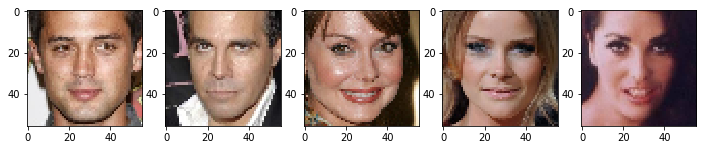

In [120]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))

for i, ax in enumerate(axes):
    ax.imshow(train_images_data[i].reshape(56, 56,3).astype(np.uint8))

## Example Prediction

In the cells below, we will train a simple classifier based on logistic regression.


In [121]:
# Performance measure
def compute_pred_score(y_true, y_pred):
    if(y_true.shape[0] != y_pred.shape[0]):
        raise Exception("y_pred and y_true must have the same size")
    tmp = np.unique(y_pred)
    if(tmp.shape[0] > 2):
        raise("y_pred should only contain 0 and 1")
        
    if(tmp.shape[0] == 1):
        if(tmp[0] != 0 and tmp[0] != 1):
            raise Exception("y_pred should only contain 0 and 1")
    else:
        if(tmp[0] != 0 and tmp[1] != 1):
            raise Exception("y_pred should only contain 0 and 1")
    
    y0 = (y_true == 0)
    y1 = (y_true == 1)
    
    acc1 = np.mean(1-y_pred[y0])
    acc2 = np.mean(y_pred[y1])
    
    return (acc1+acc2)/2

* Normalisation des données

In [122]:
train_images_data /= 255

* Encodage des labels

In [123]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(train_images_label)
encoded_Y = encoder.transform(train_images_label)
train_images_label = np_utils.to_categorical(encoded_Y)

* Je rééquilibre la classe en créant 2 vecteurs. Un vecteur contenant la classe 0 et un autre contenant la classe 1.

In [131]:
c_zero = np.argwhere(train_images_label[:, 0] == 0)
c_un = np.argwhere(train_images_label[:, 0] == 1)
train_idx = np.append(c_zero[:10000], c_un[:10000])
test_idx = np.append(c_zero[6000:10000], c_un[6000:10000])

# fix random seed for reproducibility
x_train = train_images_data[train_idx]
y_train = train_images_label[train_idx]

In [134]:
validate_idx = np.append(c_zero[10000:], c_un[10000:])
# fix random seed for reproducibility
x_validate = train_images_data[validate_idx]
y_validate = train_images_label[validate_idx]

In [149]:
# MODELE 1
nb_classes = 2

# start of architecture Convolutional neural network
model = Sequential()

model.add(Conv2D(3, (3, 3), padding='same', input_shape=train_images_data.shape[1:]))
model.add(LeakyReLU(alpha=.001))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(12, (3, 3)))
model.add(LeakyReLU(alpha=.001))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(50, (3, 3)))
model.add(LeakyReLU(alpha=.001))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(LeakyReLU(alpha=.001))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(200))
model.add(LeakyReLU(alpha=.001))
model.add(Dropout(0.25))
model.add(Dense(nb_classes))
model.add(Activation('sigmoid'))

# initiate RMSprop optimizer
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [189]:
# MODELE 2
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=train_images_data.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(nb_classes, kernel_initializer='random_uniform', activation='softmax'))


opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt, metrics=['accuracy'])

* Le modèle 1 a 3 couches et le modèle 2 en a 2 mais sont beaucoup plus profondes.
* J'ai ajouté une régularisation et une contrainte Adam pour limiter le surapprentissage.
* Le modèle 2 est très fidèle et ne sur apprend pas du tout.

In [ ]:
epochs = 20

# Fit the model
model_param = model.fit(train_images_data[train_idx],
                        train_images_label[train_idx], epochs=epochs,
                        validation_data=(
    train_images_data[test_idx], train_images_label[test_idx]))


# evaluate the model
scores = model.evaluate(x_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

Train on 20000 samples, validate on 8000 samples
Epoch 1/30
20000/20000 [==============================] - 394s 20ms/step - loss: 0.8673 - acc: 0.7835 - val_loss: 0.3885 - val_acc: 0.8481
Epoch 2/30
20000/20000 [==============================] - 251s 13ms/step - loss: 0.3787 - acc: 0.8492 - val_loss: 0.3526 - val_acc: 0.8651
Epoch 3/30
20000/20000 [==============================] - 251s 13ms/step - loss: 0.3357 - acc: 0.8727 - val_loss: 0.2947 - val_acc: 0.8908
Epoch 4/30
20000/20000 [==============================] - 251s 13ms/step - loss: 0.3154 - acc: 0.8831 - val_loss: 0.2869 - val_acc: 0.8878
Epoch 5/30
20000/20000 [==============================] - 252s 13ms/step - loss: 0.2957 - acc: 0.8883 - val_loss: 0.2757 - val_acc: 0.8961
Epoch 6/30
20000/20000 [==============================] - 251s 13ms/step - loss: 0.2873 - acc: 0.8942 - val_loss: 0.2580 - val_acc: 0.9111
Epoch 7/30
20000/20000 [==============================] - 250s 12ms/step - loss: 0.2735 - acc: 0.8985 - val_loss: 0.2

In [170]:
tmp = model.predict(x_validate)
val_p = np.argmax(tmp, axis=1)
acc_train = compute_pred_score(y_validate[:,1], val_p)
print('The score on the training data : %s' % acc_train)

The score on the training data : 0.9038336703908763


In [171]:
#tmp = model.predict(train_images_data[:80000])
#val_p = np.argmax(tmp, axis=1)
#acc_train = compute_pred_score(train_images_label[:,1], val_p)
#print('The score on the training data : %s' % acc_train)

In [172]:
# serialize weights to HDF5
model.save("model_test_reg.h5")
# serialize model to JSON
model_json = model.to_json()
with open("model_test_regjson", "w") as json_file:
    json_file.write(model_json)

In [174]:
# Generate the prediction
val_pred = model.predict(val_images_data)
val_pred = np.argmax(val_pred, axis=1)
np.savetxt("val_pred.txt", val_pred, fmt="%d")

In [11]:
# load json and create model
json_file = open('model_test_regjson', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_test_reg.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


In [12]:
# Generate the prediction
val_pred = loaded_model.predict(test_images_data)
val_pred = np.argmax(val_pred, axis=1)
np.savetxt("val_pred_test.txt", val_pred, fmt="%d")